In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

!unzip -q "/content/drive/MyDrive/handgesture.zip" -d /content/dataset

print("Unzipping complete!")

Mounted at /content/drive
Unzipping complete!


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

TRAIN_DIR = '/content/dataset/train/train'
TEST_DIR = '/content/dataset/test/test'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

print("Loading datasets...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE
)

class_names = train_ds.class_names
print(f"Detected Classes: {class_names}")

Loading datasets...
Found 18000 files belonging to 20 classes.
Found 6000 files belonging to 20 classes.
Detected Classes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']


In [11]:
from tensorflow.keras import layers, models
# Load MobileNetV2
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1)
])

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet',
    alpha=0.35
)
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Starting training")
history = model.fit(train_ds, validation_data=test_ds, epochs=15)

Starting training with Augmentation and Alpha=0.35...
Epoch 1/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.5435 - loss: 1.5779 - val_accuracy: 0.9410 - val_loss: 0.3115
Epoch 2/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.9182 - loss: 0.3247 - val_accuracy: 0.9672 - val_loss: 0.1889
Epoch 3/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.9405 - loss: 0.2199 - val_accuracy: 0.9727 - val_loss: 0.1394
Epoch 4/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.9537 - loss: 0.1735 - val_accuracy: 0.9708 - val_loss: 0.1291
Epoch 5/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - accuracy: 0.9572 - loss: 0.1519 - val_accuracy: 0.9862 - val_loss: 0.0827
Epoch 6/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.9603 - loss: 0.1360 - val_accuracy: 0.9903 - val_loss: 0.0665
Epoch 7/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 45s 52ms/step - accuracy: 0.9616 - loss: 0.1207 - val_accuracy: 0.9780 - val_loss: 0.0903
Epoch 8/15
563/563 ━━━━━━━━━━━━━━━━━

In [13]:
# 1. Get Predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Calculate Metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"\nResults:\nAccuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"F1 Score: {f1:.4f}\nRecall: {recall:.4f}\nPrecision: {precision:.4f}")

# 3. Save the model back to Google Drive
model.save('/content/drive/MyDrive/hand_gesture_model_3.h5')
print("Model saved to Drive!")

188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step



Results:
Accuracy: 0.9878
F1 Score: 0.9878
Recall: 0.9878
Precision: 0.9886
Model saved to Drive!


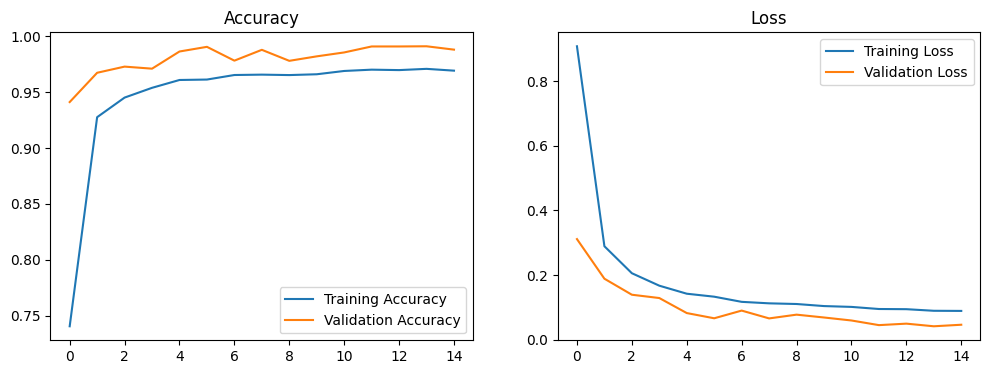

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()